In [116]:
import pandas as pd

def load_large_csv_in_chunks(
    file_path: str,
    usecols: list[str] = None,
    filter_col: str = None,
    filter_values: list[str] = None,
    chunksize: int = 100_000,
    dropna_cols: list[str] = None
) -> pd.DataFrame:
    """
    Loads a large CSV file in chunks and returns a concatenated DataFrame.
    
    Parameters:
    - file_path (str): Path to the CSV file.
    - usecols (list[str], optional): Columns to load.
    - filter_col (str, optional): Column to apply filtering on.
    - filter_values (list[str], optional): Values to keep in filter_col.
    - chunksize (int): Number of rows per chunk.
    - dropna_cols (list[str], optional): Drop rows with NaN in these columns.
    
    Returns:
    - pd.DataFrame: Filtered and loaded data in memory.
    """
    
    reader = pd.read_csv(file_path, usecols=usecols, chunksize=chunksize)
    chunks = []

    for i, chunk in enumerate(reader):
        print(f"🔄 Processing chunk {i + 1}")
        
        if dropna_cols:
            chunk = chunk.dropna(subset=dropna_cols)
        
        if filter_col and filter_values:
            chunk = chunk[chunk[filter_col].isin(filter_values)]
        
        chunks.append(chunk)
    
    df = pd.concat(chunks, ignore_index=True)
    print(f"✅ Loaded {len(df):,} rows into memory.")
    return df


In [118]:
stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA"]

stock_dfs = {}

for stock in stocks:
    file_path = f"df_{stock}_ner.csv"
    print(f"\n Loading: {file_path}")
    df = load_large_csv_in_chunks(
        file_path=file_path,
        chunksize=100_000 
    )
    stock_dfs[stock] = df


 Loading: AAPL_complete_ms.csv
🔄 Processing chunk 1
🔄 Processing chunk 2
✅ Loaded 199,363 rows into memory.

 Loading: MSFT_complete_ms.csv
🔄 Processing chunk 1
🔄 Processing chunk 2
🔄 Processing chunk 3
🔄 Processing chunk 4
🔄 Processing chunk 5
✅ Loaded 473,942 rows into memory.

 Loading: GOOGL_complete_ms.csv
🔄 Processing chunk 1
✅ Loaded 98,499 rows into memory.

 Loading: AMZN_complete_ms.csv
🔄 Processing chunk 1
✅ Loaded 75,067 rows into memory.

 Loading: NVDA_complete_ms.csv
🔄 Processing chunk 1
🔄 Processing chunk 2
✅ Loaded 110,193 rows into memory.

 Loading: META_complete_ms.csv
🔄 Processing chunk 1
✅ Loaded 70,244 rows into memory.

 Loading: TSLA_complete_ms.csv
🔄 Processing chunk 1
✅ Loaded 95,186 rows into memory.


In [129]:
stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA"]

stock_dfs = {}

for stock in stocks:
    file_path = f"df_{stock}_ner.csv"
    print(f"\n Loading: {file_path}")
    df = load_large_csv_in_chunks(
        file_path=file_path,
        chunksize=100_000 
    )
    stock_dfs[stock] = df


 Loading: df_AAPL_ner.csv
🔄 Processing chunk 1
🔄 Processing chunk 2
✅ Loaded 199,363 rows into memory.

 Loading: df_MSFT_ner.csv
🔄 Processing chunk 1
🔄 Processing chunk 2
🔄 Processing chunk 3
🔄 Processing chunk 4
🔄 Processing chunk 5
✅ Loaded 473,942 rows into memory.

 Loading: df_GOOGL_ner.csv
🔄 Processing chunk 1
✅ Loaded 98,499 rows into memory.

 Loading: df_AMZN_ner.csv
🔄 Processing chunk 1
✅ Loaded 75,067 rows into memory.

 Loading: df_NVDA_ner.csv
🔄 Processing chunk 1
🔄 Processing chunk 2
✅ Loaded 110,193 rows into memory.

 Loading: df_META_ner.csv
🔄 Processing chunk 1
✅ Loaded 70,244 rows into memory.

 Loading: df_TSLA_ner.csv
🔄 Processing chunk 1
✅ Loaded 95,186 rows into memory.


Plotting for AAPL...


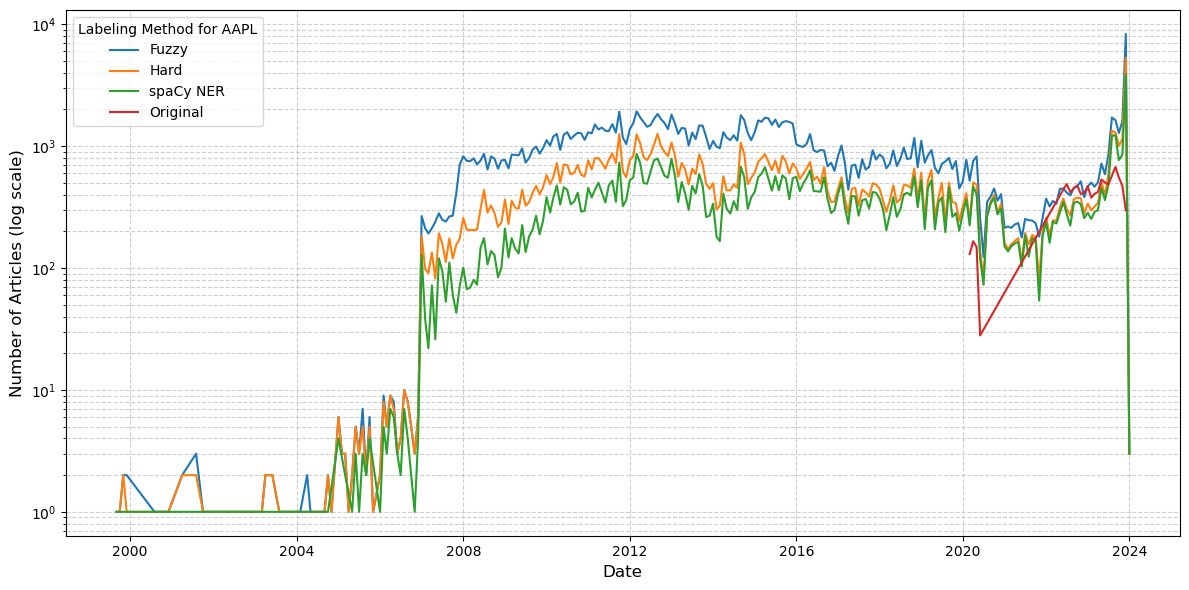

Plotting for MSFT...


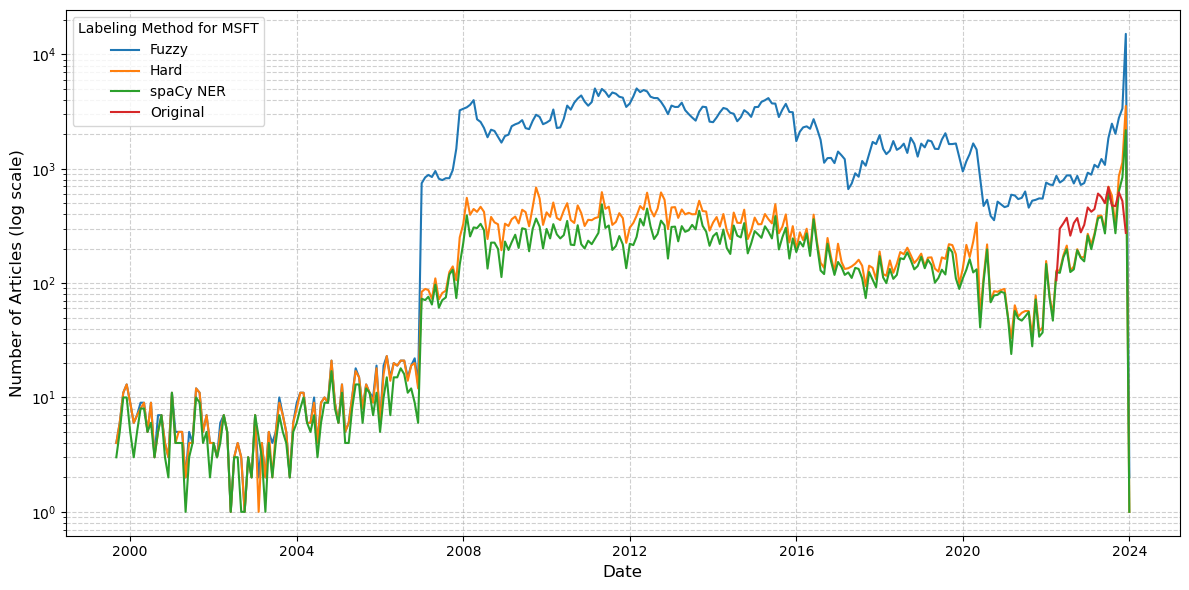

Plotting for GOOGL...


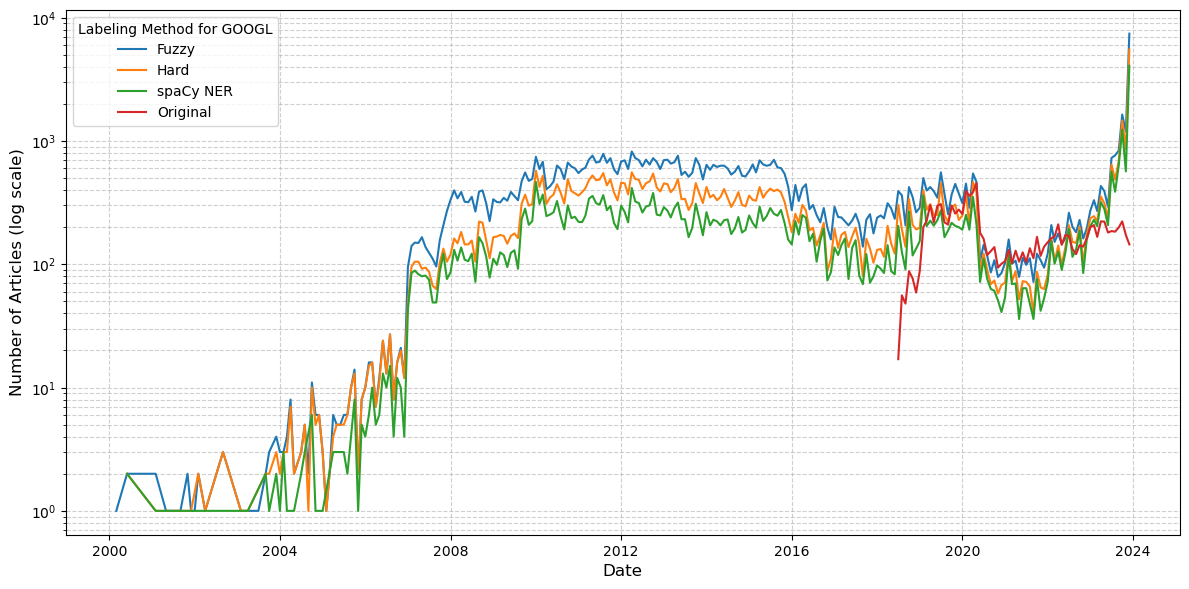

Plotting for AMZN...


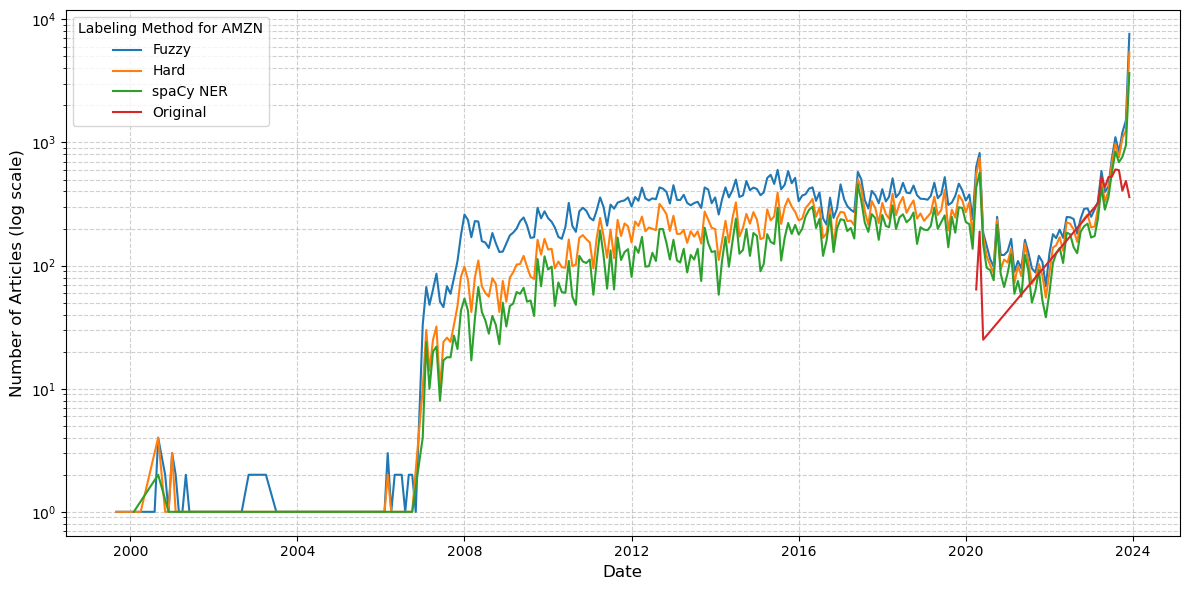

Plotting for NVDA...


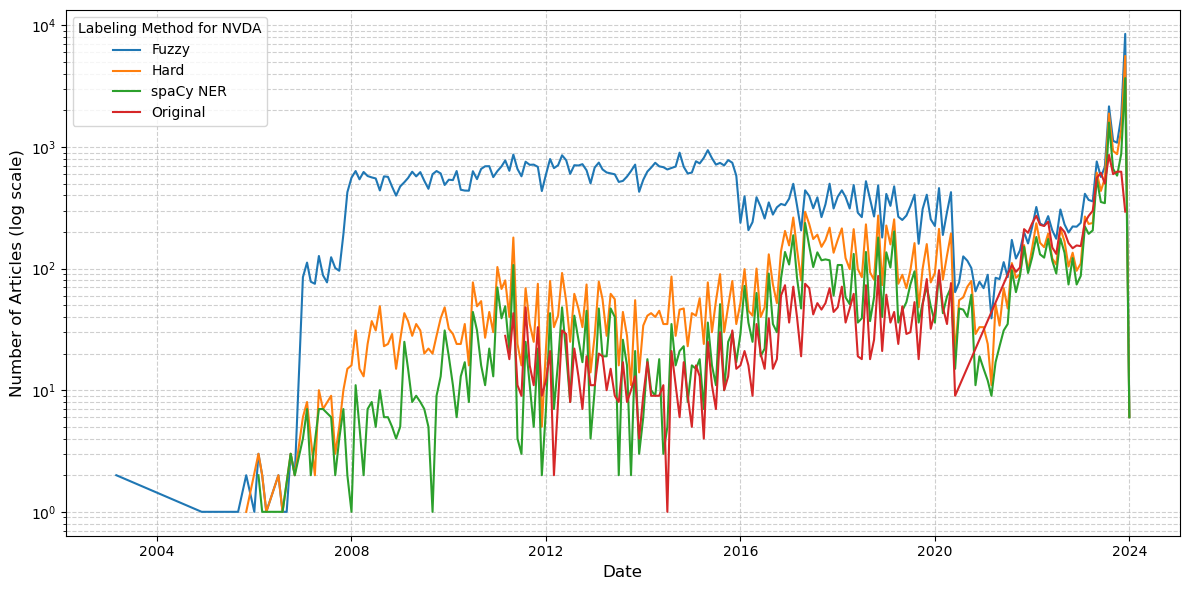

Plotting for META...


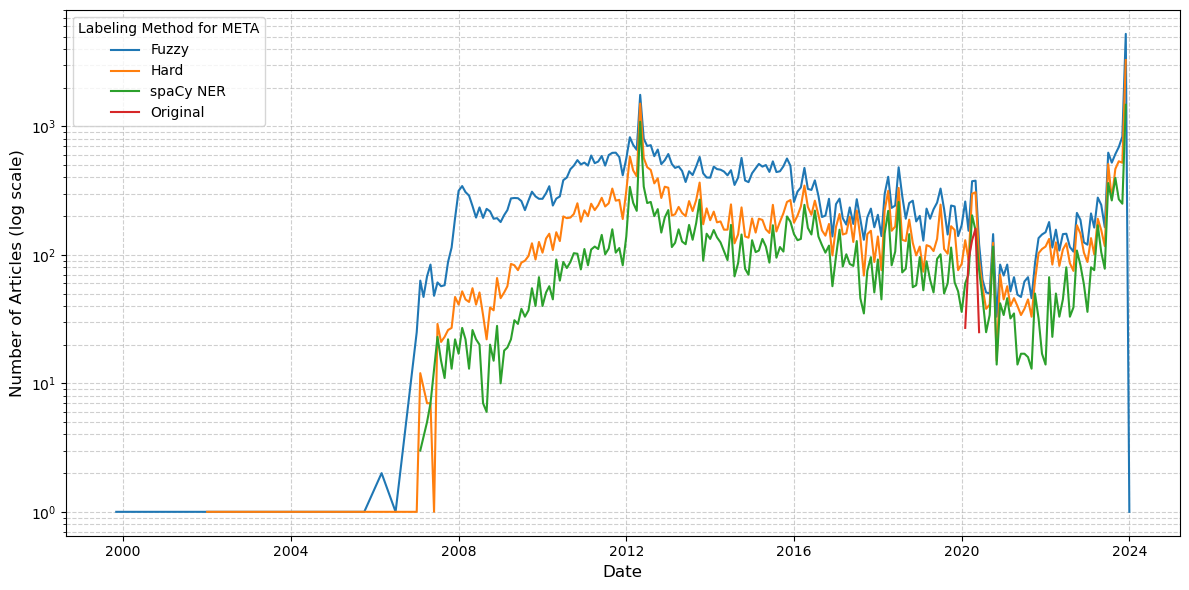

Plotting for TSLA...


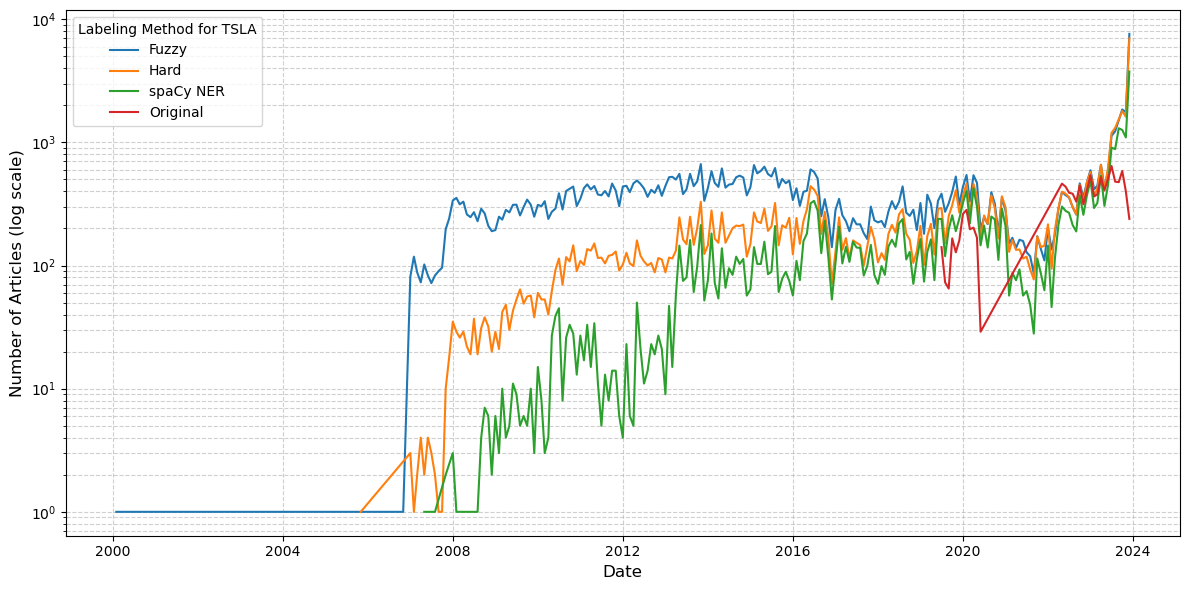

In [168]:
import matplotlib.pyplot as plt
import pandas as pd

# Custom display names for label sources
label_source_names = {
    "stock_symbol": "Original",
    "fuzzy_85_label": "Fuzzy",
    "harder_label": "Hard",
    "spacy_label": "spaCy NER"
}

for stock, df in stock_dfs.items():
    print(f"Plotting for {stock}...")

    # Ensure datetime format and remove timezone
    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.tz_localize(None)

    # Melt into long format
    df_long = pd.melt(
        df,
        id_vars=["date"],
        value_vars=list(label_source_names.keys()),
        var_name="label_source",
        value_name="label"
    )

    # Keep only rows where the label matches the current stock
    df_long = df_long[df_long["label"] == stock]

    # Count by month and label source
    df_count = df_long.groupby([
        df_long["date"].dt.to_period("M"), "label_source"
    ]).size().reset_index(name="count")

    # Convert period back to datetime
    df_count["date"] = df_count["date"].dt.to_timestamp()

    # Plot
    plt.figure(figsize=(12, 6))
    for label_source in df_count["label_source"].unique():
        subset = df_count[df_count["label_source"] == label_source]
        display_name = label_source_names.get(label_source, label_source)
        plt.plot(subset["date"], subset["count"], label=display_name)

    plt.yscale("log")  # <- Log scale for y-axis
   #plt.title(f"Number of {stock}-Labeled Articles Over Time by Labeling Method", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Number of Articles (log scale)", fontsize=12)
    plt.legend(title=f"Labeling Method for {stock}")
    plt.grid(True, linestyle="--", alpha=0.6, which="both")
    plt.tight_layout()
    plt.show()


In [135]:
import pandas as pd

# --- Config ---
stock = "TSLA"                  # The stock to inspect
label_column = "spacy_label"  # Choose among "stock_symbol", "fuzzy_85_label", "harder_label", "spacy_label"
sample_size = 50               # Number of articles to sample

# --- Pull the dataframe for the stock ---
df = stock_dfs[stock]

# --- Sample articles where the selected labeler marked the article as being about the stock ---
filtered_sample = df[df[label_column] == stock][["date", "article_title", "stock_symbol", "fuzzy_85_label", "harder_label", "spacy_label"]].sample(sample_size,
                                                                                                                                                 random_state=1666)

# --- Ensure full article titles are visible ---
pd.set_option("display.max_colwidth", None)

# --- Show result ---
filtered_sample


,date,article_title,stock_symbol,fuzzy_85_label,harder_label,spacy_label
60634,2017-07-28 00:00:00,"Apple, Tesla, Shale, Jobs To Dominate The Week: Investing Action Plan",other,TSLA,TSLA,TSLA
8022,2015-05-28 00:00:00,Can IPO SolarEdge Technologies Soar With Tesla Deal?,other,TSLA,TSLA,TSLA
51222,2015-10-07 00:00:00,Stocks Climb As Biotechs Rebound; Tesla Slips On Shift Into Neutral,other,TSLA,TSLA,TSLA
25180,2022-08-23 00:00:00,"The Zacks Analyst Blog Highlights Tesla, Airbnb, Fortinet, Oracle and Schlumberger",other,TSLA,TSLA,TSLA
76981,2010-06-28 14:54:00,Tesla increases size of IPO by 20 percent,other,TSLA,TSLA,TSLA
16893,2020-08-31 00:00:00,"After Hours Most Active for Aug 31, 2020 : KODK, ZM, AAPL, TSLA, PCG, INTC, GE, MXIM, AR, NIO, QQQ, BKU",other,TSLA,TSLA,TSLA
43022,2013-11-07 00:00:00,Could Tesla Finally Be Rolling Over?,other,TSLA,TSLA,TSLA
49333,2019-04-26 00:00:00,"The Zacks Analyst Blog Highlights: Genuine Parts, Harley-Davidson, Allison Transmission, O???Reilly Automotive and Tesla",other,TSLA,TSLA,TSLA
14294,2023-09-20 00:00:00,UAW Strike: How Tesla and EV ETFs Stand to Gain,other,TSLA,TSLA,TSLA
13396,2017-02-14 00:00:00,"Tuesday’s Vital Data: Tesla Inc (TSLA), Gilead Sciences, Inc. (GILD) and Microsoft Corporation (MSFT)",other,TSLA,TSLA,TSLA


In [137]:
# Re-import after kernel reset
import pandas as pd
import numpy as np
from scipy.stats import norm

# --- Manually entered evaluation data (correct out of 50) ---
data = {
    "Stock": ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA", "META", "TSLA"],
    "Stock_Symbol": [37, 45, 36, 37, 50, 37, 42],
    "Fuzzy_85": [29, 17, 35, 36, 16, 25, 26],
    "Hard": [45, 42, 43, 48, 49, 47, 48],
    "spaCy": [50, 50, 50, 50, 50, 50, 50],
}

# --- Population sizes per stock ---
pop_sizes = {
    "AAPL": 199_363,
    "MSFT": 473_942,
    "GOOGL": 98_499,
    "AMZN": 75_067,
    "NVDA": 110_193,
    "META": 70_244,
    "TSLA": 95_186
}

# --- Constants ---
n = 50  # sample size
z = norm.ppf(0.975)  # for 95% confidence

# --- Convert to DataFrame ---
df = pd.DataFrame(data)
df["N"] = df["Stock"].map(pop_sizes)

# --- Melt to long format ---
df_long = df.melt(id_vars=["Stock", "N"], var_name="Labeler", value_name="Correct")

# --- Compute statistics ---
df_long["p_hat"] = df_long["Correct"] / n
df_long["Var(p_hat)"] = (df_long["p_hat"] * (1 - df_long["p_hat"]) / n) * ((df_long["N"] - n) / (df_long["N"] - 1))
df_long["CI Lower"] = df_long["p_hat"] - z * np.sqrt(df_long["Var(p_hat)"])
df_long["CI Upper"] = df_long["p_hat"] + z * np.sqrt(df_long["Var(p_hat)"])

# --- Format output ---
df_stats = df_long[["Stock", "Labeler", "p_hat", "Var(p_hat)", "CI Lower", "CI Upper"]]


In [128]:
df_stats

,Stock,Labeler,p_hat,Var(p_hat),CI Lower,CI Upper
0,AAPL,Stock_Symbol,0.74,0.003847,0.618434,0.861566
1,MSFT,Stock_Symbol,0.90,0.001800,0.816850,0.983150
2,AMZN,Stock_Symbol,0.72,0.004029,0.595587,0.844413
3,GOOGL,Stock_Symbol,0.74,0.003846,0.618449,0.861551
4,NVDA,Stock_Symbol,1.00,0.000000,1.000000,1.000000
5,META,Stock_Symbol,0.74,0.003845,0.618461,0.861539
6,TSLA,Stock_Symbol,0.84,0.002687,0.738410,0.941590
7,AAPL,Fuzzy_85,0.58,0.004871,0.443212,0.716788
8,MSFT,Fuzzy_85,0.34,0.004488,0.208704,0.471296
9,AMZN,Fuzzy_85,0.70,0.004197,0.573021,0.826979


In [201]:
def weighted_vote(row, stock, weights):
    score = 0
    for label_col, weight in weights.items():
        if row[label_col] == stock:
            score += weight
    return stock if score > 0.4 else "other"

In [202]:
# Step 1: Raw accuracy scores
raw_accuracy_dict = {
    "TSLA":  {"stock_symbol": 42, "fuzzy_85_label": 26, "harder_label": 48, "spacy_label": 50},
    "AAPL":  {"stock_symbol": 37, "fuzzy_85_label": 29, "harder_label": 45, "spacy_label": 50},
    "MSFT":  {"stock_symbol": 45, "fuzzy_85_label": 17, "harder_label": 42, "spacy_label": 50},
    "NVDA":  {"stock_symbol": 50, "fuzzy_85_label": 16, "harder_label": 49, "spacy_label": 50},
    "GOOGL": {"stock_symbol": 37, "fuzzy_85_label": 36, "harder_label": 48, "spacy_label": 50},
    "AMZN":  {"stock_symbol": 36, "fuzzy_85_label": 35, "harder_label": 43, "spacy_label": 49},
    "META":  {"stock_symbol": 37, "fuzzy_85_label": 25, "harder_label": 47, "spacy_label": 50}
}

# Step 2: Normalize weights per stock
normalized_weights = {}
for stock, scores in raw_accuracy_dict.items():
    total = sum(scores.values())
    normalized_weights[stock] = {k: v / total for k, v in scores.items()}

# Step 3: Apply weighted voting using per-stock weights
final_dfs = {}
for stock, df in stock_dfs.items():
    weights = normalized_weights[stock]
    df["final_label"] = df.apply(lambda row: weighted_vote(row, stock, weights), axis=1)
    final_dfs[stock] = df


In [197]:
for stock, weights in normalized_weights.items():
    print(f"{stock}: {weights}")

TSLA: {'stock_symbol': 0.25301204819277107, 'fuzzy_85_label': 0.1566265060240964, 'harder_label': 0.2891566265060241, 'spacy_label': 0.30120481927710846}
AAPL: {'stock_symbol': 0.22981366459627328, 'fuzzy_85_label': 0.18012422360248448, 'harder_label': 0.2795031055900621, 'spacy_label': 0.3105590062111801}
MSFT: {'stock_symbol': 0.2922077922077922, 'fuzzy_85_label': 0.11038961038961038, 'harder_label': 0.2727272727272727, 'spacy_label': 0.3246753246753247}
NVDA: {'stock_symbol': 0.30303030303030304, 'fuzzy_85_label': 0.09696969696969697, 'harder_label': 0.296969696969697, 'spacy_label': 0.30303030303030304}
GOOGL: {'stock_symbol': 0.21637426900584794, 'fuzzy_85_label': 0.21052631578947367, 'harder_label': 0.2807017543859649, 'spacy_label': 0.29239766081871343}
AMZN: {'stock_symbol': 0.22085889570552147, 'fuzzy_85_label': 0.2147239263803681, 'harder_label': 0.26380368098159507, 'spacy_label': 0.3006134969325153}
META: {'stock_symbol': 0.23270440251572327, 'fuzzy_85_label': 0.15723270440

In [173]:
final_dfs["MSFT"].head(50)

,index,date,article_title,stock_symbol,fuzzy_85_label,harder_label,spacy_label,final_label
0,53,2023-08-16,Stocks Mixed as Markets Await Minutes of the July FOMC Meeting,other,MSFT,other,other,other
1,61,2023-08-16,Stocks Slightly Higher as Markets Await Minutes of the July FOMC Meeting,other,MSFT,other,other,other
2,123,2023-05-18,Vipshop (VIPS) to Post Q1 Earnings: What's in the Offing?,other,MSFT,other,other,other
3,137,2023-05-15,Wix.com (WIX) to Report Q1 Earnings: What's in the Offing?,other,MSFT,other,other,other
4,143,2023-05-12,Baidu (BIDU) to Post Q1 Earnings: What's in the Offing?,other,MSFT,other,other,other
5,146,2023-05-11,Agilent (A) Forms 'Hammer Chart Pattern': Time for Bottom Fishing?,other,MSFT,other,other,other
6,147,2023-05-10,JD.com (JD) to Report Q1 Earnings: What's in the Offing?,other,MSFT,other,other,other
7,156,2023-05-08,Twilio (TWLO) to Report Q1 Earnings: What's in the Offing?,other,MSFT,other,other,other
8,158,2023-05-08,Waters (WAT) to Report Q1 Earnings: What's in the Offing?,other,MSFT,other,other,other
9,166,2023-05-05,PayPal (PYPL) to Post Q1 Earnings: What's in the Offing?,other,MSFT,other,other,other


📈 Plotting for AAPL...


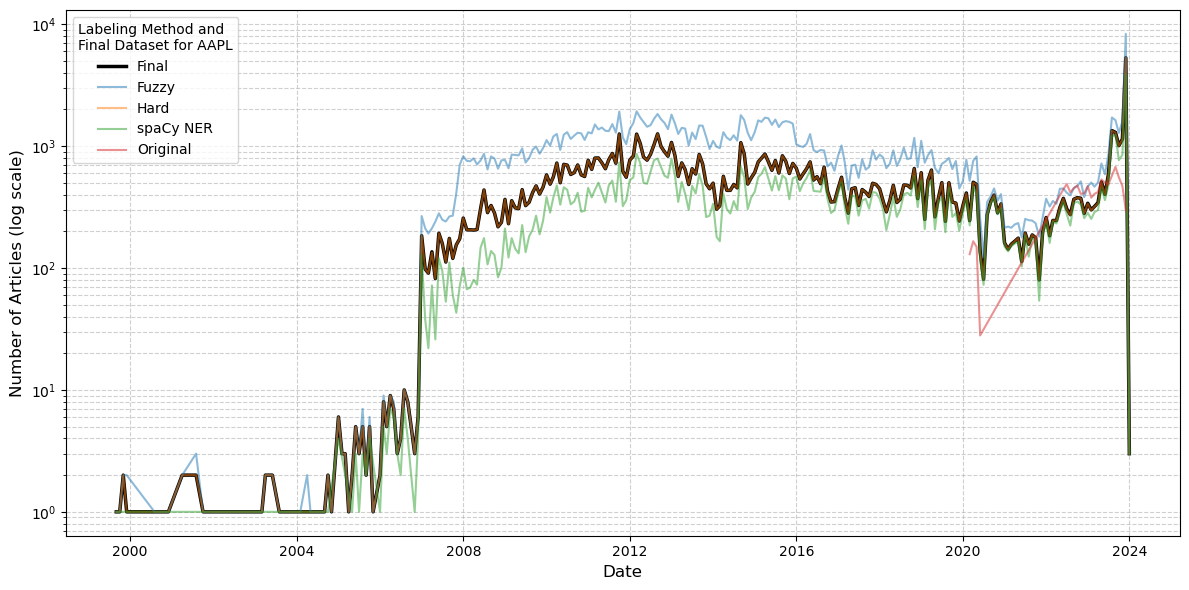

📈 Plotting for MSFT...


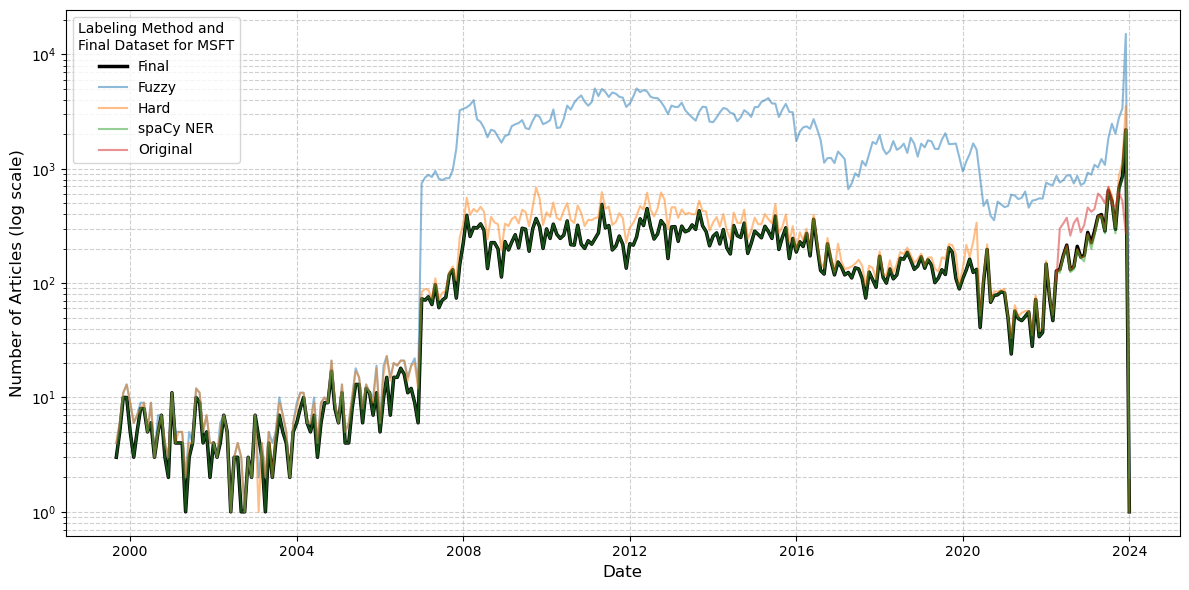

📈 Plotting for GOOGL...


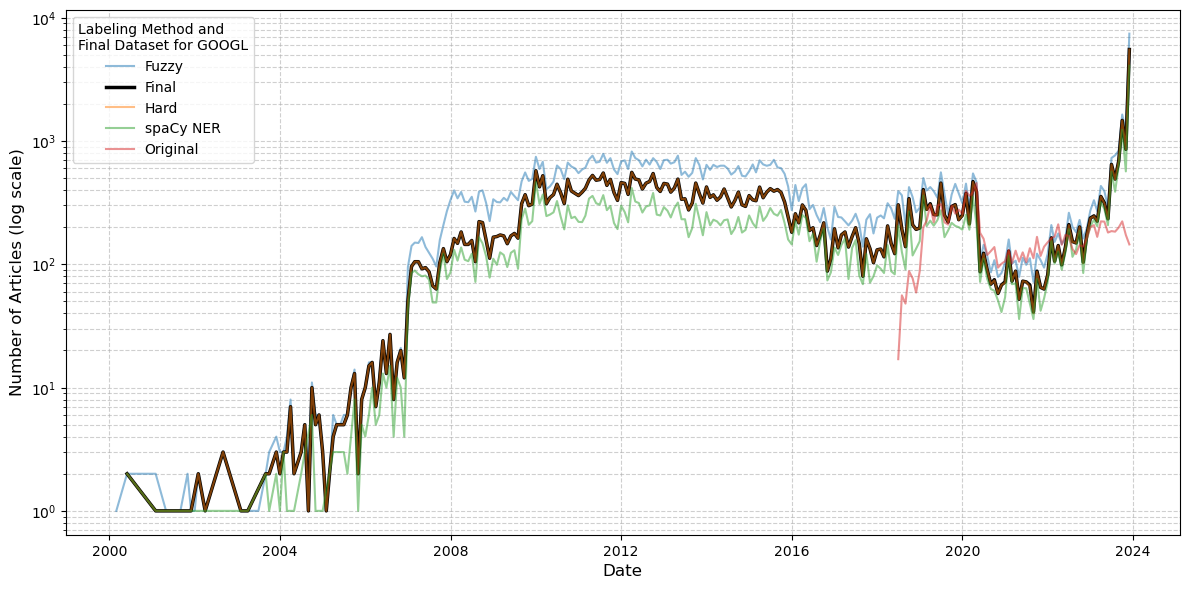

📈 Plotting for AMZN...


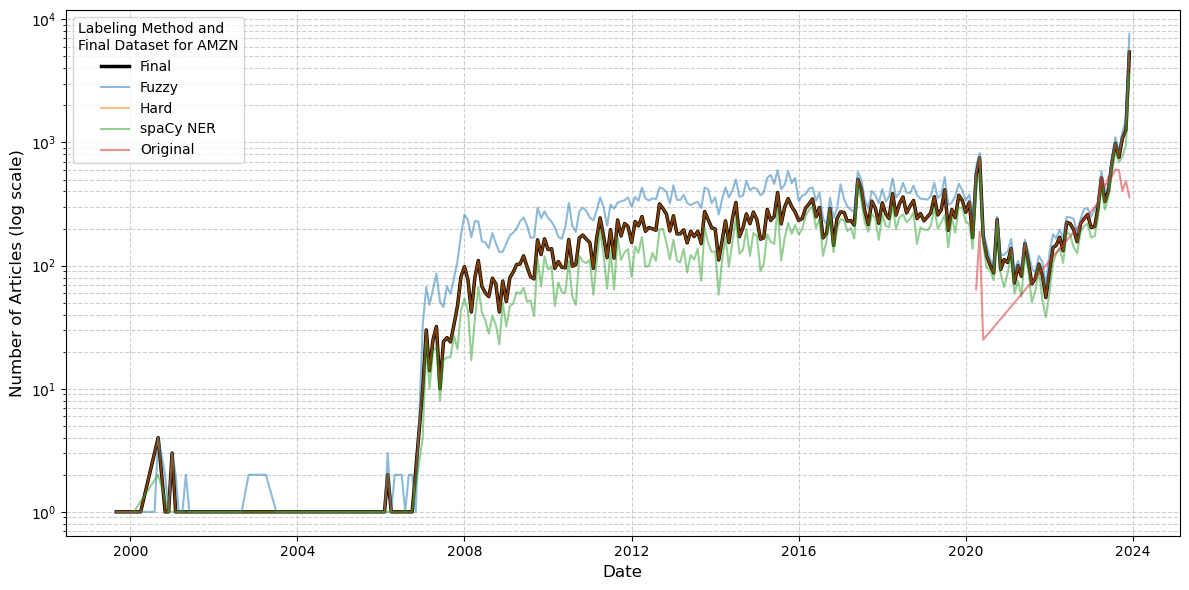

📈 Plotting for NVDA...


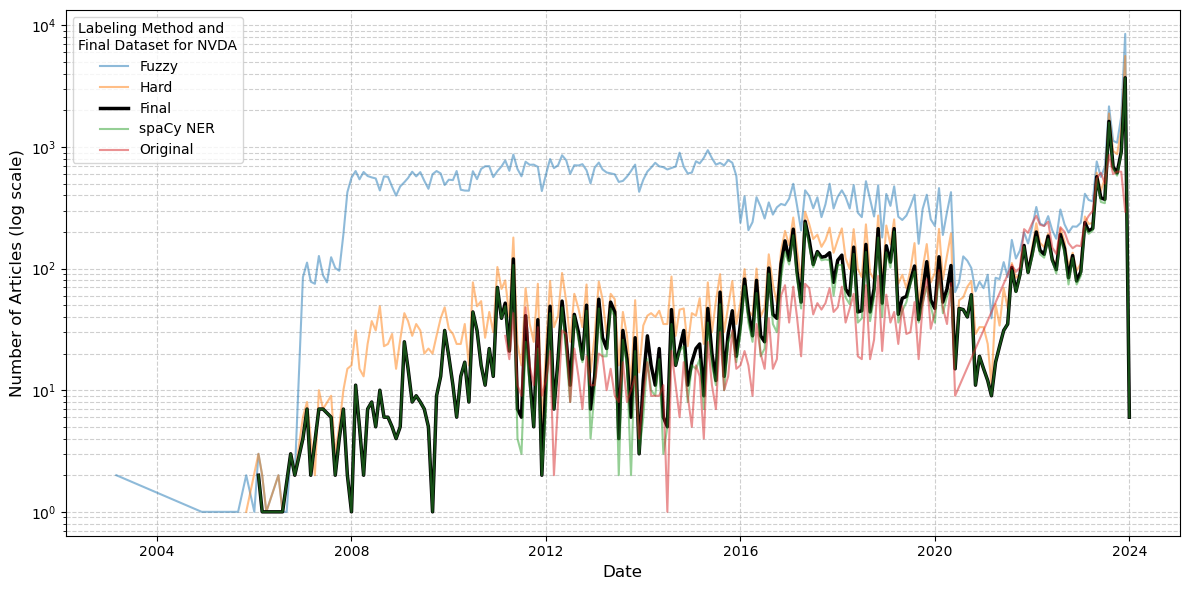

📈 Plotting for META...


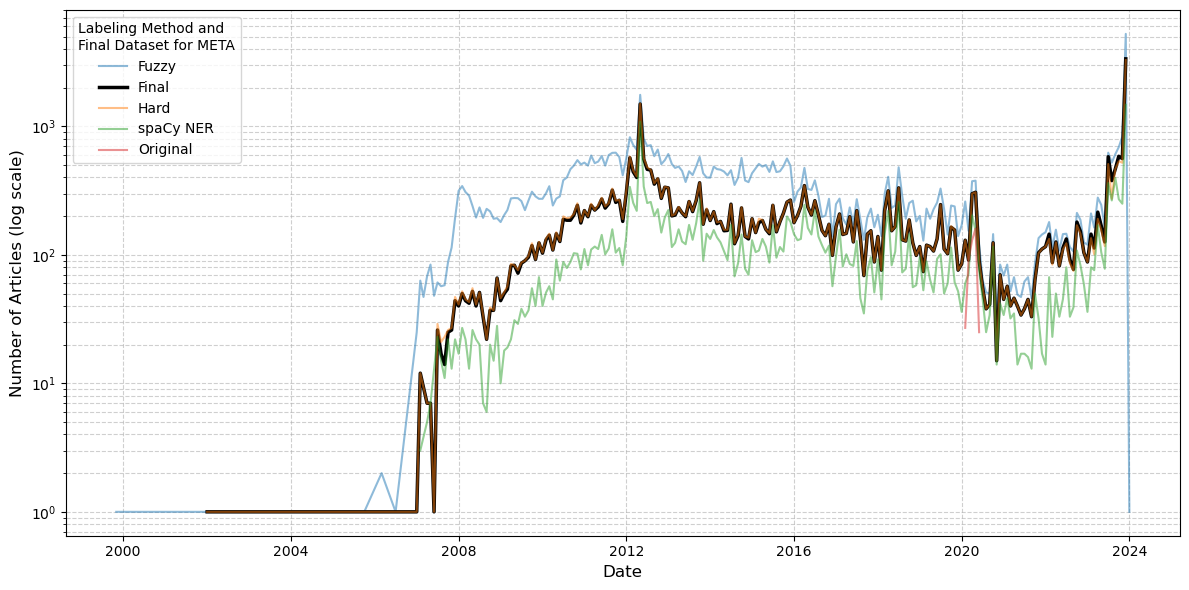

📈 Plotting for TSLA...


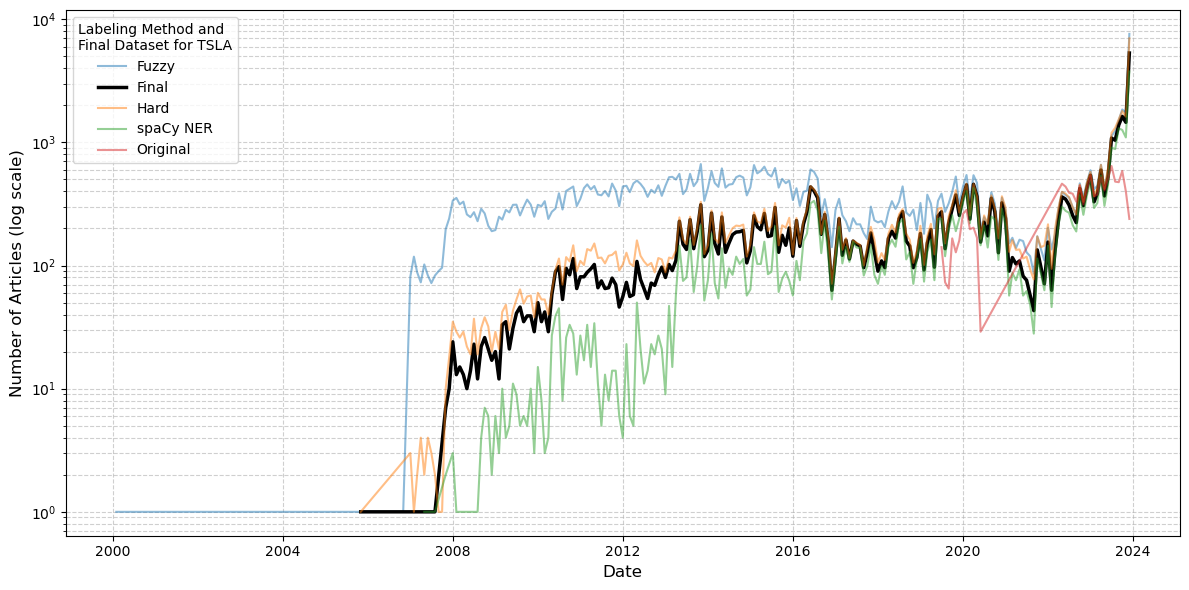

In [208]:
import matplotlib.pyplot as plt
import pandas as pd

# Custom display names for label sources
label_source_names = {
    "stock_symbol": "Original",
    "fuzzy_85_label": "Fuzzy",
    "harder_label": "Hard",
    "spacy_label": "spaCy NER",
    "final_label": "Final"
}

# Custom styles for highlighting
highlight_label = "final_label"

for stock, df in final_dfs.items():
    print(f"📈 Plotting for {stock}...")

    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.tz_localize(None)

    df_long = pd.melt(
        df,
        id_vars=["date"],
        value_vars=list(label_source_names.keys()),
        var_name="label_source",
        value_name="label"
    )

    df_long = df_long[df_long["label"] == stock]

    df_count = df_long.groupby([
        df_long["date"].dt.to_period("M"),
        "label_source"
    ]).size().reset_index(name="count")
    df_count["date"] = df_count["date"].dt.to_timestamp()

    # Plot
    plt.figure(figsize=(12, 6))

    for label_source in df_count["label_source"].unique():
        subset = df_count[df_count["label_source"] == label_source]
        display_name = label_source_names.get(label_source, label_source)

        if label_source == highlight_label:
            plt.plot(
                subset["date"], subset["count"],
                label=display_name,
                linewidth=2.5,
                alpha=1.0,
                color="black"
            )
        else:
            plt.plot(
                subset["date"], subset["count"],
                label=display_name,
                linewidth=1.5,
                alpha=0.5  # <- Transparency for comparison lines
            )

    plt.yscale("log")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Number of Articles (log scale)", fontsize=12)
   #plt.title(f"Ensemble Model Application for {stock}", fontsize=13)
    plt.legend(title=f"Labeling Method and\nFinal Dataset for {stock}", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6, which="both")
    plt.tight_layout()
    plt.show()


In [209]:
# Extract rows with a valid final label for each stock
final_label_dfs = {}

for stock, df in final_dfs.items():
    filtered = df[df["final_label"] == stock][["index", "final_label"]]
    final_label_dfs[stock] = filtered


In [211]:
for stock, df in final_label_dfs.items():
    print(f"{stock}: {len(df)} rows")

AAPL: 104345 rows
MSFT: 45110 rows
GOOGL: 60794 rows
AMZN: 48957 rows
NVDA: 19223 rows
META: 37873 rows
TSLA: 41017 rows


In [212]:
for stock, df in final_label_dfs.items():
    filename = f"{stock}_final_labels.csv"
    df.to_csv(filename, index=False)
    print(f"✅ Saved {filename}")

✅ Saved AAPL_final_labels.csv
✅ Saved MSFT_final_labels.csv
✅ Saved GOOGL_final_labels.csv
✅ Saved AMZN_final_labels.csv
✅ Saved NVDA_final_labels.csv
✅ Saved META_final_labels.csv
✅ Saved TSLA_final_labels.csv
